In [2]:
from numpy.polynomial.polynomial import Polynomial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from help_functions_non_njit import *
import seaborn as sns
from scipy.stats import multivariate_normal, lognorm, norm
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial import Polynomial
from graph_format import custom_palette, save_figure
from sklearn.linear_model import LinearRegression

# Indbetalingsprocent

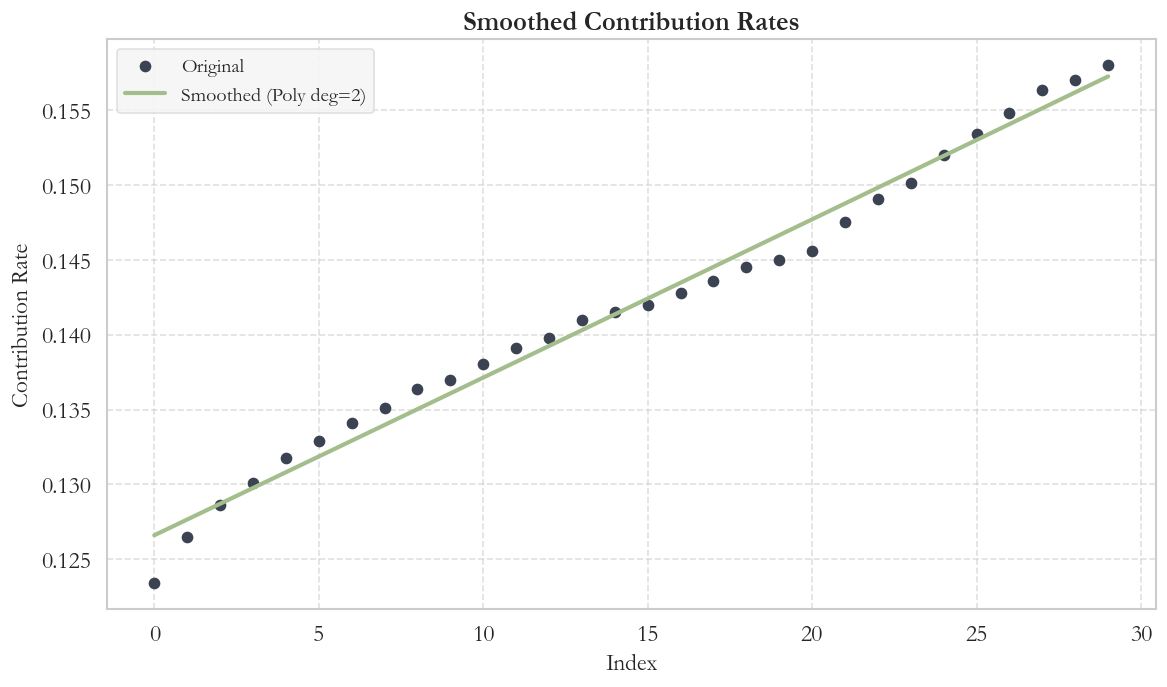

In [3]:
# Apply plot style
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Load and clean data
indbet = np.array(pd.read_csv("Data/mean_matrix.csv")['indbetalingsprocent_sum'])
indbet = indbet[~np.isnan(indbet)][:30]

# Prepare data
x = np.arange(len(indbet))
y = indbet

# Fit polynomial of degree 2
coefs = Polynomial.fit(x, y, deg=2)
y_smooth = coefs(x)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label='Original', color=custom_palette[0])
plt.plot(x, y_smooth, label='Smoothed (Poly deg=2)', color=custom_palette[1], linewidth=2.5)

plt.xlabel("Index", fontsize=14)
plt.ylabel("Contribution Rate", fontsize=14)
plt.title("Smoothed Contribution Rates", fontsize=16, fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save the figure
save_figure(plt.gcf(), "smoothed_indbetalingsprocent.png")
plt.show()

# Save smoothed results
years = np.arange(70)
co = coefs(years)
pd.DataFrame(co, columns=['indbetalingsprocent_sum']).to_csv("Smooth_data/smooth_indbet.csv", index=False)


In [8]:
coefs

Polynomial([1.41883068e-01, 1.53206141e-02, 4.24767275e-05], domain=[ 0., 29.], window=[-1.,  1.])

# Overlevelses ssh

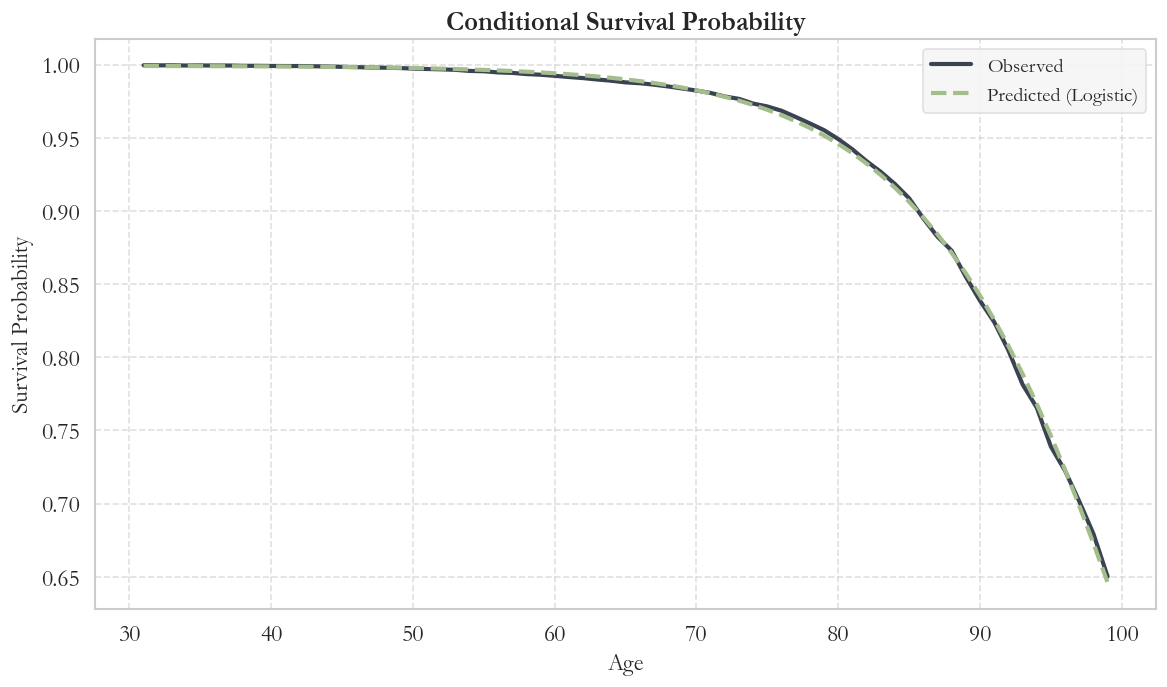

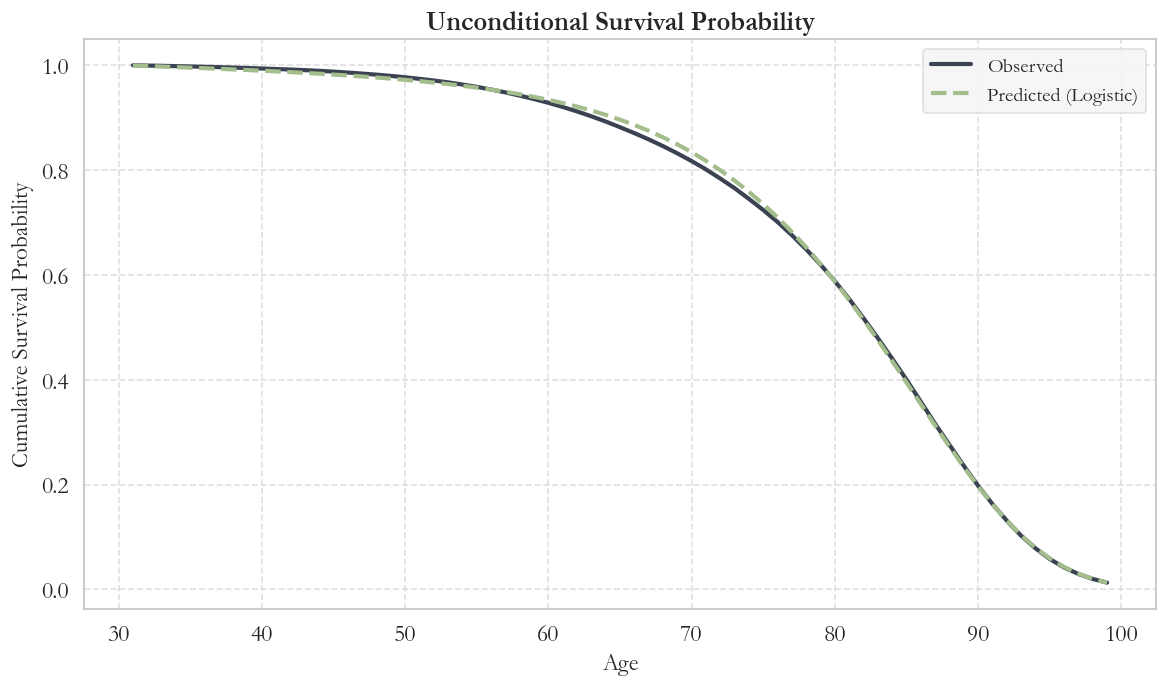

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graph_format import custom_palette, save_figure

# Apply consistent styling
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Define logistic function
def logistic(x, L, f, x0):
    return L / (1 + np.exp(-f * (x - x0)))

# Load and process data
df = pd.read_csv('Data/overlevelse_ssh.csv')
L, f, x0 = 0.9992, -0.1195, 74.0520
df['predicted'] = logistic(df['alder'], L, f, x0)
df['observed_unconditional'] = np.cumprod(df['survival_Mean'])
df['predicted_unconditional'] = np.cumprod(df['predicted'])

# === Conditional Survival Plot ===
plt.figure(figsize=(10, 6))
plt.plot(df['alder'] + 30, df['survival_Mean'], label='Observed', color=custom_palette[0], linewidth=2.5)
plt.plot(df['alder'] + 30, df['predicted'], label='Predicted (Logistic)', color=custom_palette[1], linestyle='--', linewidth=2.5)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Survival Probability', fontsize=14)
plt.title("Conditional Survival Probability", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
save_figure(plt.gcf(), "conditional_survival_fit.png")
plt.show()

# === Unconditional Survival Plot ===
plt.figure(figsize=(10, 6))
plt.plot(df['alder'] + 30, df['observed_unconditional'], label='Observed', color=custom_palette[0], linewidth=2.5)
plt.plot(df['alder'] + 30, df['predicted_unconditional'], label='Predicted (Logistic)', color=custom_palette[1], linestyle='--', linewidth=2.5)

plt.xlabel('Age', fontsize=14)
plt.ylabel('Cumulative Survival Probability', fontsize=14)
plt.title("Unconditional Survival Probability", fontsize=16, fontweight="bold")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
save_figure(plt.gcf(), "unconditional_survival_fit.png")
plt.show()

# Optional: Save predicted unconditional survival data
df[['alder', 'predicted']].to_csv("Smooth_data/survival_ssh.csv", index=False)


# Transitions ssh for employment

In [17]:
df = pd.read_csv("Data/parameter_estiamtes_simpel.csv")[['Variable', 'Response',  'Estimate']]


# state_1_multiplier = 2

everything = []
# for e_state_lag in [0.0, 1.0]:
total_1 = []
total_2 = []
for x in range(70):
    eta = {1: 0.0, 2: 0.0}

    for e_state in [1.0, 2.0]: 
        df_state = df[df['Response'] == e_state]
        for _, row in df_state.iterrows():
            var = row["Variable"]
            estimate = row["Estimate"]
            
            if var == 'Intercept':
                eta[e_state] = estimate
            elif var == 'alder':
                eta[e_state] += estimate * x
            # elif var == 'alder2':
            #     eta[e_state] += estimate * x**2
            elif var == "dummy_60_65":
                if x >= 31:
                    eta[e_state] += estimate

    total_1.append(eta[1])
    total_2.append(eta[2])


group_0 = []
group_1 = []    
group_2 = []
for x in range(70):
    # if 40 > x >= 35:
    #     group_0.append(0.0)
    #     group_1.append(np.exp(total_1[x])/(np.exp(total_1[x]) + np.exp(total_2[x])))
    #     group_2.append(np.exp(total_2[x])/(np.exp(total_1[x]) + np.exp(total_2[x])))
    # elif 40 > x > 35:
    #     group_0.append(0.0)
    #     group_1.append(group_1[-1])
    #     group_2.append(group_2[-1])
    # elif x >= 40 and e_state_lag == 1.0:
    #     group_0.append(0.0)
    #     group_1.append(0.0)
    #     group_2.append(1.0)
    if x >= 40:
        group_0.append(0.0)
        group_1.append(0.0)
        group_2.append(1.0)
    else:
        group_0.append(1/(1+np.exp(total_1[x]) + np.exp(total_2[x])))
        group_1.append(np.exp(total_1[x])/(1+np.exp(total_1[x]) + np.exp(total_2[x])))
        group_2.append(np.exp(total_2[x])/(1+np.exp(total_1[x]) + np.exp(total_2[x])))

probabilites =  {'to_0': group_0, 'to_1': group_1, 'to_2': group_2}
everything.append(probabilites)


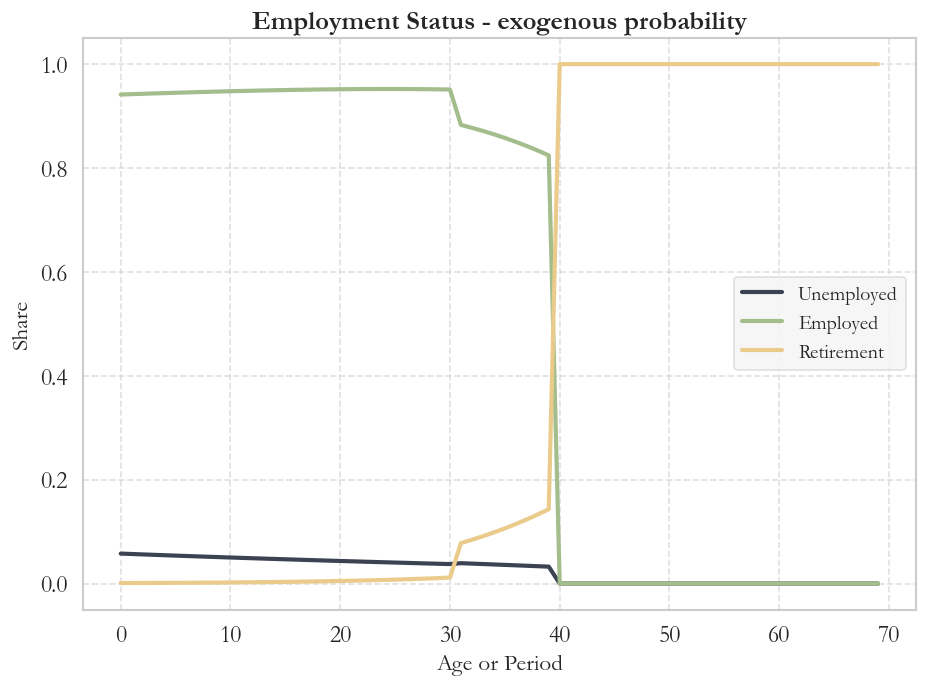

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from graph_format import custom_palette, save_figure

# Apply style
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Assuming `from_sth` is already defined
plt.figure(figsize=(8, 6))

plt.plot(everything[0]['to_0'], label='Unemployed', color=custom_palette[0], linewidth=2.5)
plt.plot(everything[0]['to_1'], label='Employed', color=custom_palette[1], linewidth=2.5)
plt.plot(everything[0]['to_2'], label='Retirement', color=custom_palette[2], linewidth=2.5)

plt.xlabel("Age or Period", fontsize=14)
plt.ylabel("Share", fontsize=14)
plt.title("Employment Status - exogenous probability", fontsize=16, fontweight="bold")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save using standard method
save_figure(plt.gcf(), "group_transitions_over_time.png")
plt.show()


# Skatteprocenterne

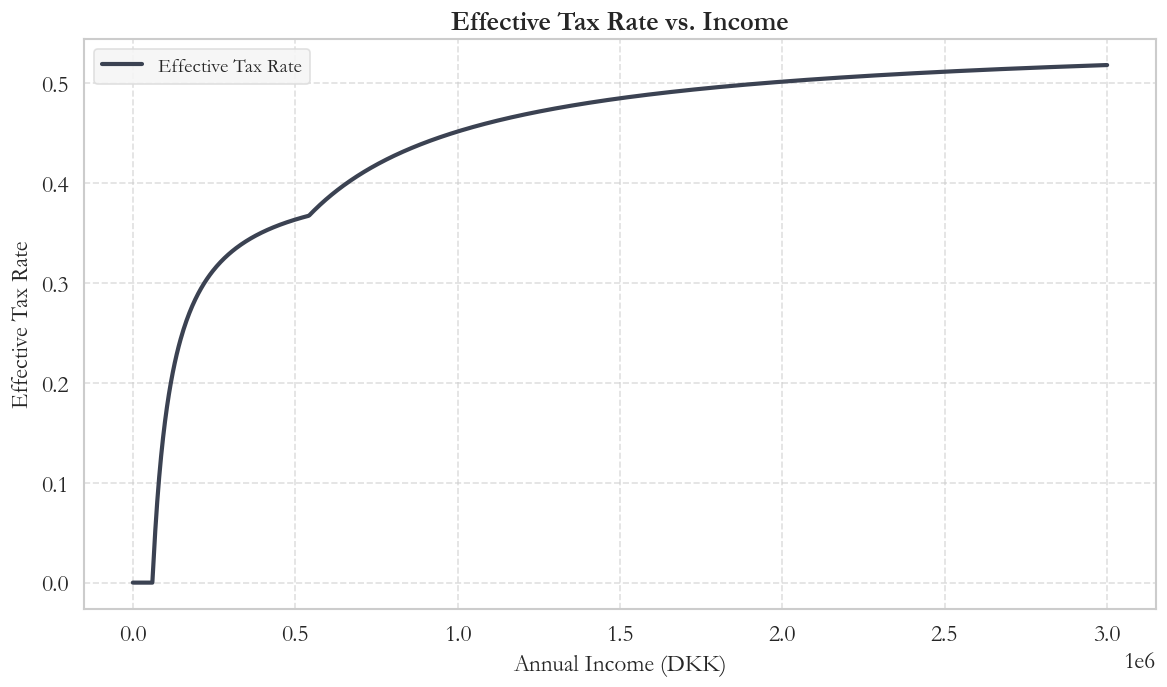

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graph_format import custom_palette, save_figure

# Apply global styling
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Tax constants
am_sats = 0.08
beskfradrag_sats = 0.875
bundskat_sats = 0.113
topskat_sats = 0.15
kommuneskat_sats = 0.2491
personfradrag = 46000
beskfradrag_graense = 33300
topskat_graense = 498900

def calculate_tax_rate(ind_aar):
    am_aar = ind_aar * am_sats
    personlignd_aar = ind_aar - am_aar
    grundlag_aar = max(personlignd_aar - personfradrag, 0)
    beskfradrag_aar = min(beskfradrag_graense, ind_aar * beskfradrag_sats)
    skattepligt_aar = grundlag_aar - beskfradrag_aar
    bundskat_aar = grundlag_aar * bundskat_sats
    topskat_aar = topskat_sats * max(personlignd_aar - topskat_graense, 0)
    kommuneskat_aar = kommuneskat_sats * skattepligt_aar
    indkomstskat_aar = am_aar + bundskat_aar + topskat_aar + kommuneskat_aar
    ind_efter_aar = ind_aar - indkomstskat_aar
    skatteprocent_aar = max(1 - (ind_efter_aar / ind_aar), 0)
    return skatteprocent_aar

# Generate data
incomes = np.linspace(1, 3_000_000, 1000)
tax_rates = [calculate_tax_rate(x) for x in incomes]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(incomes, tax_rates, label="Effective Tax Rate", color=custom_palette[0], linewidth=2.5)
plt.xlabel("Annual Income (DKK)", fontsize=14)
plt.ylabel("Effective Tax Rate", fontsize=14)
plt.title("Effective Tax Rate vs. Income", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Save and show
save_figure(plt.gcf(), "effective_tax_rate_vs_income.png")
plt.show()


# Initial values 

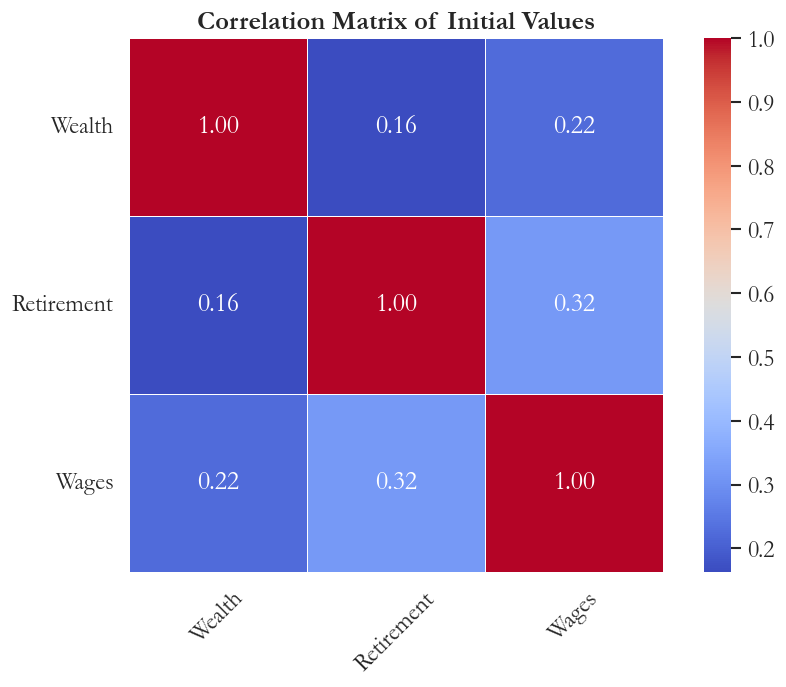

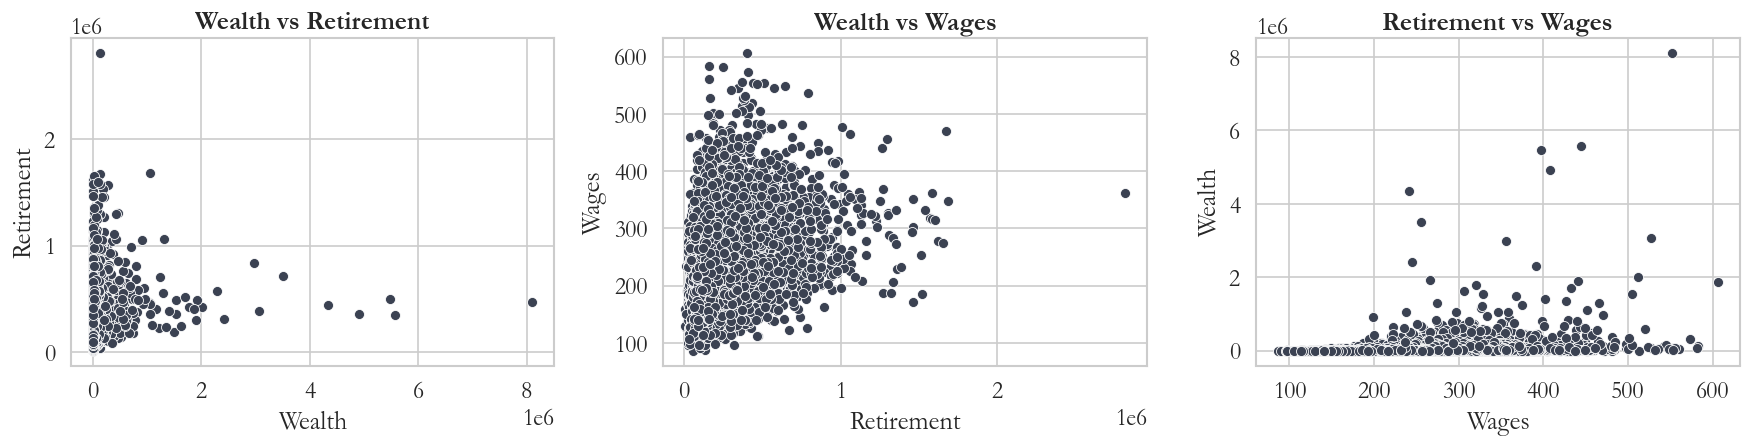

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from graph_format import save_figure, custom_palette  # Use defined styling tools

# Apply consistent styling
sns.set_theme(context="notebook", style="whitegrid", font="garamond", palette=custom_palette, font_scale=1.3)

# Simulate data
wealth, retirement, wages = draw_initial_values(10000)
df = pd.DataFrame({
    "Wealth": wealth,
    "Retirement": retirement,
    "Wages": wages
})

# === Correlation Matrix Heatmap ===
corr_matrix = df.corr()

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True,
                      linewidths=0.5, linecolor='white', square=True)

plt.title("Correlation Matrix of Initial Values", fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

save_figure(plt.gcf(), "correlation_matrix_initial_values.png")

# === Pairplot ===
# pairplot = sns.pairplot(df, corner=True, plot_kws={"alpha": 0.6})
# pairplot.fig.suptitle("Pairplot of Initial Values", fontsize=16, fontweight="bold", y=1.02)

pairplot = plt.figure(figsize=(15, 4))

# Wealth vs Retirement
plt.subplot(1, 3, 1)
sns.scatterplot(x='Wealth', y='Retirement', data=df)
plt.title('Wealth vs Retirement')

# Wealth vs Wages
plt.subplot(1, 3, 2)
sns.scatterplot(x='Retirement', y='Wages', data=df)
plt.title('Wealth vs Wages')

# Retirement vs Wages
plt.subplot(1, 3, 3)
sns.scatterplot(x='Wages', y='Wealth', data=df)
plt.title('Retirement vs Wages')

plt.tight_layout()
plt.show()

# Save figure using the assigned object
save_figure(pairplot, "pairplot_initial_values.png")



# Renter på pensionsformue

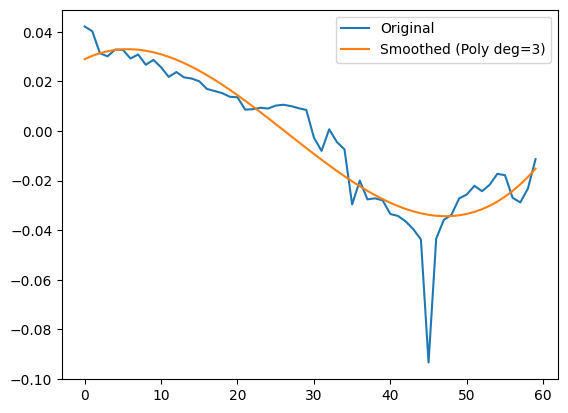

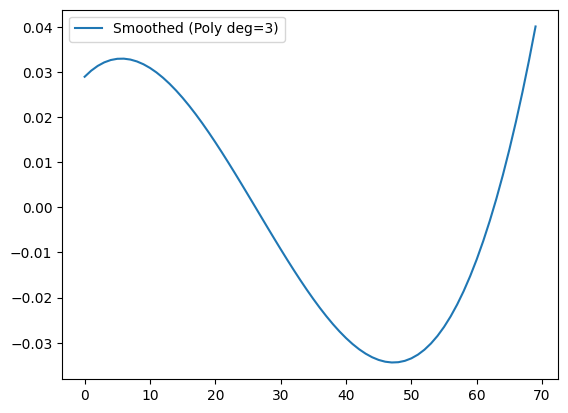

In [20]:
rente = np.array(pd.read_csv("Data/mean_matrix.csv")['rente_pension_sum'])
rente = rente[~np.isnan(rente)][:60]

x_r = np.arange(len(rente))  # or actual x values

# Fit polynomial of degree 3
coefs = Polynomial.fit(x_r, rente, deg=3)
rente_smooth = coefs(x_r)

# Plot
plt.plot(x_r, rente, label='Original')
plt.plot(x_r, rente_smooth, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co = coefs(years)


T = 70
x_T = np.arange(T)
rente_smooth_long = coefs(x_T)


# Plot
plt.plot(x_T, rente_smooth_long, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()


pd.DataFrame(rente_smooth_long).rename(columns={0: 'rente_s'}).to_csv("Smooth_data/smooth_rente_s.csv", index=False)



In [21]:
rente = np.array(pd.read_csv("Data/mean_matrix.csv")['rente_pension_sum'])
np.mean(np.array(pd.read_csv("Data/mean_matrix.csv")['rente_pension_sum'])[:60])

np.float64(-0.0029413226416666665)

# Early retirement benefits

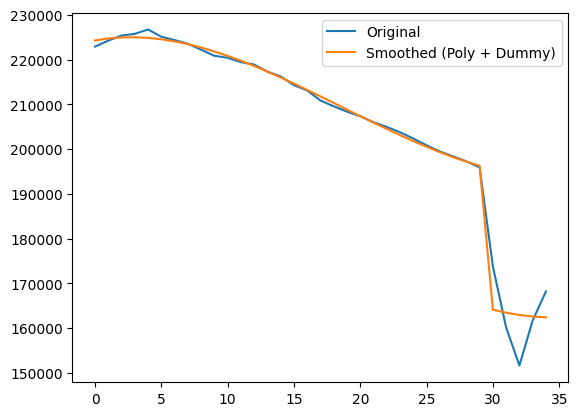

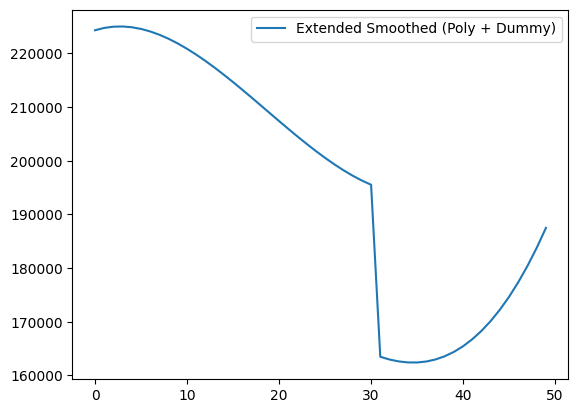

In [22]:
# Load data
overfor_2 = pd.read_csv('data/mean_matrix.csv')['overfor_2']
overfor_2 = overfor_2[~np.isnan(overfor_2)][:40]

# Set x values
x_r = np.arange(len(overfor_2))

# Create polynomial features
X_poly = np.vstack([x_r**i for i in range(4)]).T  # deg 3 -> x^0, x^1, x^2, x^3

# Create dummy variable for x > 30
dummy = (x_r >= 30).astype(int).reshape(-1, 1)

# Combine polynomial features and dummy
X = np.hstack([X_poly, dummy])

# Fit linear model
model = LinearRegression().fit(X, overfor_2)

# Predict smoothed values on same range
overfor_2_smooth = model.predict(X)

# Plot original and smoothed
plt.plot(x_r, overfor_2, label='Original')
plt.plot(x_r, overfor_2_smooth, label='Smoothed (Poly + Dummy)')
plt.legend()
plt.show()

# Extend prediction to 70 years
years = np.arange(50)
X_poly_long = np.vstack([years**i for i in range(4)]).T
dummy_long = (years > 30).astype(int).reshape(-1, 1)
X_long = np.hstack([X_poly_long, dummy_long])
co_long = model.predict(X_long)

# Plot extended prediction
plt.plot(years, co_long, label='Extended Smoothed (Poly + Dummy)')
plt.legend()
plt.show()

# Gem koefficietnerne til modellen
model.coef_[0] = model.intercept_
np.savetxt('coefs_early_benefit.csv', model.coef_, delimiter=',')

# Unemployment benefits

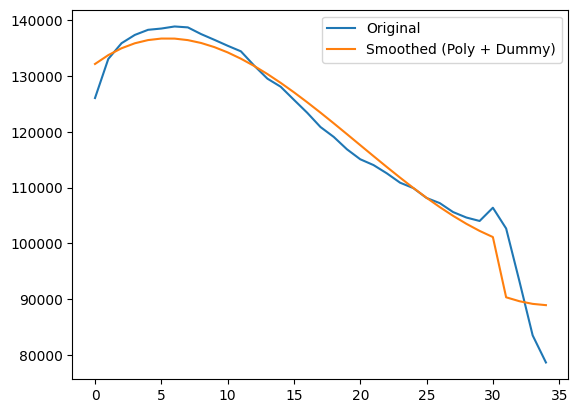

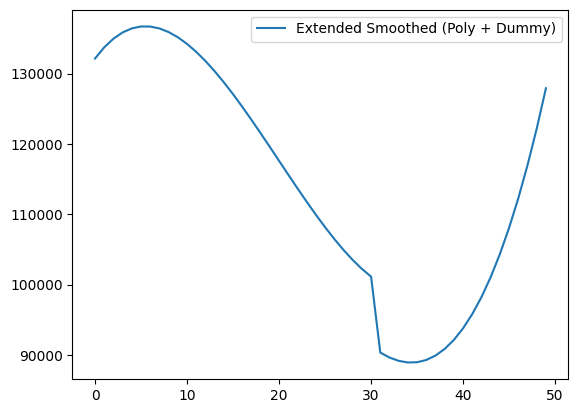

In [23]:
# Load data
overfor_0 = pd.read_csv('data/mean_matrix.csv')['overfor_0']
overfor_0 = overfor_0[~np.isnan(overfor_0)][:40]

# Set x values
x_r = np.arange(len(overfor_0))

# Create polynomial features
X_poly = np.vstack([x_r**i for i in range(4)]).T  # deg 3 -> x^0, x^1, x^2, x^3

# Create dummy variable for x > 30
dummy = (x_r > 30).astype(int).reshape(-1, 1)

# Combine polynomial features and dummy
X = np.hstack([X_poly, dummy])

# Fit linear model manually (no sklearn needed)
coefs, _, _, _ = np.linalg.lstsq(X, overfor_0, rcond=None)

# Plot original and smoothed
overfor_0_smooth = X @ coefs

plt.plot(x_r, overfor_0, label='Original')
plt.plot(x_r, overfor_0_smooth, label='Smoothed (Poly + Dummy)')
plt.legend()
plt.show()

# Extend prediction to 50 years
years = np.arange(50)
X_poly_long = np.vstack([years**i for i in range(4)]).T
dummy_long = (years > 30).astype(int).reshape(-1, 1)
X_long = np.hstack([X_poly_long, dummy_long])

# Predict extended
co_long = X_long @ coefs

plt.plot(years, co_long, label='Extended Smoothed (Poly + Dummy)')
plt.legend()
plt.show()


# Gem koefficietnerne til modellen
np.savetxt('coefs_unemployment_benefit.csv', model.coef_, delimiter=',')

# Employment benefits

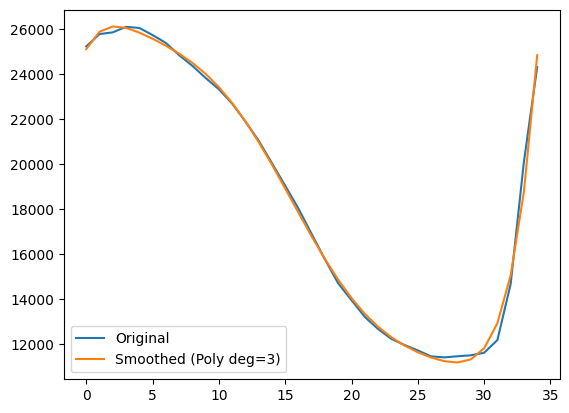

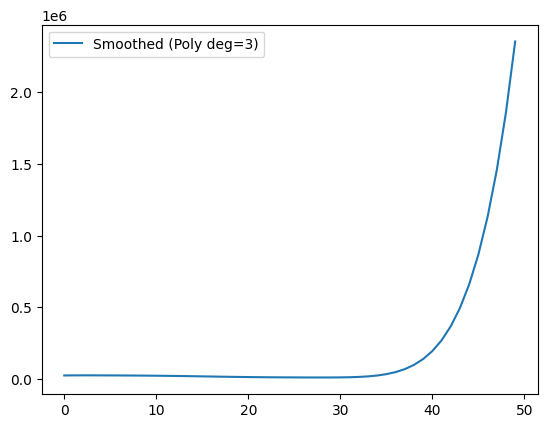

In [24]:
overfor_1 = pd.read_csv('data/mean_matrix.csv')['overfor_1']

overfor_1 = overfor_1[~np.isnan(overfor_1)][:40]

x_r = np.arange(len(overfor_1))  # or actual x values

# Fit polynomial of degree 3
coefs = Polynomial.fit(x_r, overfor_1, deg=7)
overfor_1_smooth = coefs(x_r)

# Plot
plt.plot(x_r, overfor_1, label='Original')
plt.plot(x_r, overfor_1_smooth, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co = coefs(years)

T = 50
x_T = np.arange(T)
overfor_1_smooth_long = coefs(x_T)

# Plot
plt.plot(x_T, overfor_1_smooth_long, label='Smoothed (Poly deg=3)')
plt.legend()
plt.show()
years = np.arange(70)
co_long = coefs(years)

